# Chess Move Tracking ♟️: End-to-End Computer Vision Pipeline

---
**Author:** Surawut Kittikaiwan
**Date:** December 2025

---

## Abstract
This notebook demonstrates a complete pipeline for tracking chess moves from a video feed and converting them into standard **PGN (Portable Game Notation)** format. The system handles real-world challenges such as:
-  **Occlusions:** Hands blocking the board during moves.
-  **Perspective:** Angled camera views (not perfectly top-down).
-  **Dynamic Initialization:** Supporting both full games (start to finish) and mid-game scenarios without prior knowledge of the active turn.

## Pipeline Architecture
The solution is divided into 4 distinct phases:
1.  **Phase 1: Board Localization (YOLO11-Pose)** - Detecting board corners and applying perspective warping.
2.  **Phase 2: Piece Detection (YOLO11)** - Identifying chess pieces and hands on the warped board.
3.  **Phase 3: State Analysis (Logic)** - Mapping detections to grid coordinates, filtering noise, and detecting move events.
4.  **Phase 4: Rules & PGN (Python-Chess)** - Validating moves against chess rules and generating the final game record.

> **ℹ️ Note Regarding Model Training:**
>
> Please note that the training procedures for `YOLO11` (Phase 1 & Phase 2) are **not included** in this notebook execution to maintain efficiency, as training typically requires significant GPU resources and time.
>
> Instead, this notebook utilizes **pre-trained weights** that I have already fine-tuned and hosted on **Hugging Face**. The pipeline will automatically download these models to perform inference immediately.

## Setup & Installation

In [ ]:
# Install required libraries
%pip install -U ultralytics
%pip install opencv-python
%pip install chess
%pip install gdown
%pip install editdistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 74.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=60847550136ca918e7dba481f3cc2dc5624b718ddada632aaaa1f28f62beb22c
  Stored in directory: /root/.cache/pip/wheels/83/1f/4e/8f4300f7dd554eb8de70ddfed96e94d3d030ace10c5b53d447
Successfully built chess


## Download Test Videos

In [2]:
!wget https://drive.google.com/uc?id=19WEt-PW6vetxU9gIPl48RRWEe8I2BDV5 -O chess_solution_final_seen.csv

--2025-12-11 13:24:32--  https://drive.google.com/uc?id=19WEt-PW6vetxU9gIPl48RRWEe8I2BDV5
Resolving drive.google.com (drive.google.com)... 142.250.101.139, 142.250.101.101, 142.250.101.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.101.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=19WEt-PW6vetxU9gIPl48RRWEe8I2BDV5 [following]
--2025-12-11 13:24:32--  https://drive.usercontent.google.com/download?id=19WEt-PW6vetxU9gIPl48RRWEe8I2BDV5
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.101.132, 2607:f8b0:4023:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.101.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1030 (1.0K) [application/octet-stream]
Saving to: ‘chess_solution_final_seen.csv’

chess_solution_fina 100%[===================>]   1.01K  --.-KB/s    in 0s      

2025-12-11 13

In [3]:
# Load videos (or you can upload videos here manually)
import gdown

f = open('./chess_solution_final_seen.csv', 'r')
head = f.readline()
for line in f:
  video_name, moves_sol, p, link = line.split(',')
  idx = link.find('/d/')
  idx2 = link.find('/',idx+3)
  print(link[idx+3:idx2])
  url = 'https://drive.google.com/uc?id=' + link[idx+3:idx2]

  print(url, video_name)
  gdown.download(url, output=video_name, quiet=False)

19OwlC54feylOiEkuOq3inyWCzBdA3MSU
https://drive.google.com/uc?id=19OwlC54feylOiEkuOq3inyWCzBdA3MSU 2_Move_rotate_student.mp4


Downloading...
From: https://drive.google.com/uc?id=19OwlC54feylOiEkuOq3inyWCzBdA3MSU
To: /content/2_Move_rotate_student.mp4
100%|██████████| 58.8M/58.8M [00:00<00:00, 81.7MB/s]


1mcLXdCYUKoAc7NgMLytBekof9ZtEBjZ1
https://drive.google.com/uc?id=1mcLXdCYUKoAc7NgMLytBekof9ZtEBjZ1 2_move_student.mp4


Downloading...
From: https://drive.google.com/uc?id=1mcLXdCYUKoAc7NgMLytBekof9ZtEBjZ1
To: /content/2_move_student.mp4
100%|██████████| 58.0M/58.0M [00:00<00:00, 92.9MB/s]


10eGU7YRdk75W57MwBr5I5alm21xtX3og
https://drive.google.com/uc?id=10eGU7YRdk75W57MwBr5I5alm21xtX3og 4_Move_studet.mp4


Downloading...
From (original): https://drive.google.com/uc?id=10eGU7YRdk75W57MwBr5I5alm21xtX3og
From (redirected): https://drive.google.com/uc?id=10eGU7YRdk75W57MwBr5I5alm21xtX3og&confirm=t&uuid=30eab6d4-9bd8-4bf0-88dd-93ff9eba15c0
To: /content/4_Move_studet.mp4
100%|██████████| 116M/116M [00:00<00:00, 132MB/s]


1-ngWrvLtN5-CA2eTPefr2A0r4UFQ1HsU
https://drive.google.com/uc?id=1-ngWrvLtN5-CA2eTPefr2A0r4UFQ1HsU 6_Move_student.mp4


Downloading...
From (original): https://drive.google.com/uc?id=1-ngWrvLtN5-CA2eTPefr2A0r4UFQ1HsU
From (redirected): https://drive.google.com/uc?id=1-ngWrvLtN5-CA2eTPefr2A0r4UFQ1HsU&confirm=t&uuid=e55ea0c8-d3fc-4c33-9ffd-1db8c44835fb
To: /content/6_Move_student.mp4
100%|██████████| 109M/109M [00:00<00:00, 110MB/s] 


1gWIQywW5ByxC9pkcAruOUEhLGOk2Xyqk
https://drive.google.com/uc?id=1gWIQywW5ByxC9pkcAruOUEhLGOk2Xyqk 8_Move_student.mp4


Downloading...
From (original): https://drive.google.com/uc?id=1gWIQywW5ByxC9pkcAruOUEhLGOk2Xyqk
From (redirected): https://drive.google.com/uc?id=1gWIQywW5ByxC9pkcAruOUEhLGOk2Xyqk&confirm=t&uuid=d98bcf70-eb4c-4531-9aa0-b8eac21e2d13
To: /content/8_Move_student.mp4
100%|██████████| 567M/567M [00:05<00:00, 95.6MB/s]


1DvH3Hb2rY1Dn6NNNl0Gbkifry303rEP2
https://drive.google.com/uc?id=1DvH3Hb2rY1Dn6NNNl0Gbkifry303rEP2 (Bonus)Long_Video_label.mp4


Downloading...
From (original): https://drive.google.com/uc?id=1DvH3Hb2rY1Dn6NNNl0Gbkifry303rEP2
From (redirected): https://drive.google.com/uc?id=1DvH3Hb2rY1Dn6NNNl0Gbkifry303rEP2&confirm=t&uuid=4157179e-ce4e-49cb-83f0-f229fb421773
To: /content/(Bonus)Long_Video_label.mp4
100%|██████████| 541M/541M [00:04<00:00, 130MB/s] 


## 🧩 Phase 1: Board Localization & Perspective Warping

**Objective:** To isolate the chessboard from the environment and transform it into a standardized 640x640 top-down view.

### ⚙️ Methodology:
We use a pretrained **YOLO11-Pose** model as the baseline model and then fine-tune it on our custom chessboard dataset to detect 4 semantic keypoints (corners) on the chessboard: `a1`, `h1`, `a8`, and `h8`. Using these points, we calculate a **Homography Matrix** to un-warp the image, correcting camera angle and rotation.

### 🗝️Key Components:
* `Model`: Fine-tuned YOLO11s-Pose
* `BoardLocalizer`: A class to handles chessboard detection and perspective transformation using fine-tuned YOLO11s-Pose.

### 1.1 Dataset Preparation
To train the `YOLO11-Pose` model to accurately detect the four semantic corners of the chessboard (a1, h1, a8, h8) under varying camera angles and environmental conditions. We create a custom dataset focusing on chessboard corners detection. See more details about this dataset [**here**](https://huggingface.co/datasets/surawut/chessboard-dataset-yolo).

**Data Source:** Raw video frames were extracted from a diverse collection of gameplay footage. The source videos include `2_Move`, `2_Move_rotate`, `6_Move`, `8_Move`, `(Bonus)Long_video`, and additional data including chessboard images in various angles.

**Composition:**
1) **Rotation:** Included frames rotated at 0°, 90°, and 180° to enforce rotation invariance.
2) **Occlusion:** Explicitly included frames where **hands cover the board corners**. The model learns to infer the corner position even when hidden.

**Splitting Strategy:** The dataset was divided at the video level rather than the frame level to prevent data leakage (ensuring the model generalizes to unseen camera setups):
- Training Set: Frames from `2_Move_rotate`, `6_Move`, `(Bonus)Long_video` + addtional data
- Validation Set: Frames from `2_Move` and `8_Move`.

**Labeling (Semantic Keypoints)**
* Class: `chessboard`
* Keypoints (Ordered): `a1` (White's Bottom-Left), `h1`, `a8`, `h8`.
* *Note:* Keypoints are labeled based on their **semantic meaning** (e.g., a1 is always a1), not their visual position in the frame.

**Preprocessing:** The following pre-processing was applied to each image:
1. Auto-orientation of pixel data (with EXIF-orientation stripping)
2. Resize to 640x640 (Stretch)
    
**Augmentations:** The following augmentation was applied to create 3 versions of each source image:
1. Random brigthness adjustment of between -15 and +15 percent
2. Random exposure adjustment of between -15 and +15 percent
3. Random Gaussian blur of between 0 and 1 pixels
4. Salt and pepper noise was applied to 1.25 percent of pixels


**Final Dataset Composition:** The final dataset structure used for training is summarized below:

| Split | Base Images | Post-Augmentation (3x) | Source |
| :--- | :--- | :--- | :--- |
| **Train** | 1130 | 3390 |`2_Move_rotate`, `6_Move`, `(Bonus)Long_video` + Addtional Data |
| **Valid** | 290 | 290 | `2_Move`, `8_Move` |

### 1.2 YOLO11s-pose Model Evaluation Results

In [4]:
# Download the Validation Dataset
import gdown
import zipfile
import os

def download_and_extract_gdrive(gdrive_url, output_folder="."):
    """
    Downloads a ZIP file from Google Drive and extracts it.

    Args:
        gdrive_url (str): The full Google Drive shareable link.
        output_folder (str): The directory where files will be extracted.
    """
    # 1. Extract the File ID from the URL
    # Google Drive URLs usually look like: https://drive.google.com/file/d/FILE_ID/view...
    try:
        file_id = gdrive_url.split('/d/')[1].split('/')[0]
    except IndexError:
        print("❌ Error: Could not extract File ID. Please check the Google Drive URL.")
        return

    # 2. Download the file using gdown
    # We set a temporary name for the downloaded zip
    output_zip = "temp_download.zip"
    print(f"⬇️ Downloading file (ID: {file_id})...")
    # gdown handles the download (including large file warnings automatically)
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, output_zip, quiet=False)

    # 3. Extract the ZIP file
    if os.path.exists(output_zip):
        print(f"📦 Extracting to '{output_folder}'...")
        # Create output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)
        try:
            with zipfile.ZipFile(output_zip, 'r') as zip_ref:
                zip_ref.extractall(output_folder)
            print("✅ Extraction complete!")

            # 4. Clean up (Optional: remove the zip file after extraction)
            os.remove(output_zip)
            print("🧹 Removed temporary zip file.")

        except zipfile.BadZipFile:
            print("❌ Error: The downloaded file is not a valid ZIP file.")
    else:
        print("❌ Download failed.")


# Run the function to download the validation dataset
google_drive_link = "https://drive.google.com/file/d/1tiWPf0b81jRqE-mHIUt9yADNkOqGwqHg/view?usp=sharing"
download_and_extract_gdrive(google_drive_link, output_folder="./chessboard-dataset")

⬇️ Downloading file (ID: 1tiWPf0b81jRqE-mHIUt9yADNkOqGwqHg)...


Downloading...
From (original): https://drive.google.com/uc?id=1tiWPf0b81jRqE-mHIUt9yADNkOqGwqHg
From (redirected): https://drive.google.com/uc?id=1tiWPf0b81jRqE-mHIUt9yADNkOqGwqHg&confirm=t&uuid=6f0935d7-4be6-41ba-bfff-8a24fcde546a
To: /content/temp_download.zip
100%|██████████| 224M/224M [00:05<00:00, 43.0MB/s]


📦 Extracting to './chessboard-dataset'...
✅ Extraction complete!
🧹 Removed temporary zip file.


In [ ]:
# Validate the YOLO-pose model on validation set
from ultralytics import YOLO

POSE_MODEL_URL = 'https://huggingface.co/surawut/chess-move-tracking-yolo11/resolve/main/models/yolo11s_pose_chessboard.pt'
pose_model = YOLO(POSE_MODEL_URL)

val_results = pose_model.val(
        data='./chessboard-dataset/data.yaml',
        split='val',
        project='./runs/validation',
        name='yolo11s_pose_val',
        batch=16,
        save=True,
        exist_ok=True,
        verbose=True
)

results_dict = val_results.results_dict
print(f'\nBox Precision: {results_dict["metrics/precision(B)"]}')
print(f'Box Recall: {results_dict["metrics/recall(B)"]}')
print(f'Box mAP50: {results_dict["metrics/mAP50(B)"]}')
print(f'Box mAP50-95: {results_dict["metrics/mAP50-95(B)"]}')
print(f'Pose Precision: {results_dict["metrics/precision(P)"]}')
print(f'Pose Recall: {results_dict["metrics/recall(P)"]}')
print(f'Pose mAP50: {results_dict["metrics/mAP50(P)"]}')
print(f'Pose mAP50-95: {results_dict["metrics/mAP50-95(P)"]}')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-pose summary (fused): 109 layers, 9,700,263 parameters, 0 gradients, 22.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1431.9±483.3 MB/s, size: 34.1 KB)
val: Scanning /content/chessboard-dataset/valid/labels... 290 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 290/290 1.6Kit/s 0.2s
val: New cache created: /content/chessboard-dataset/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 2.3it/s 8.3s
                   all        290        290          1

### 1.3 Visualize the Fine-tuned `YOLO11s-Pose` Output

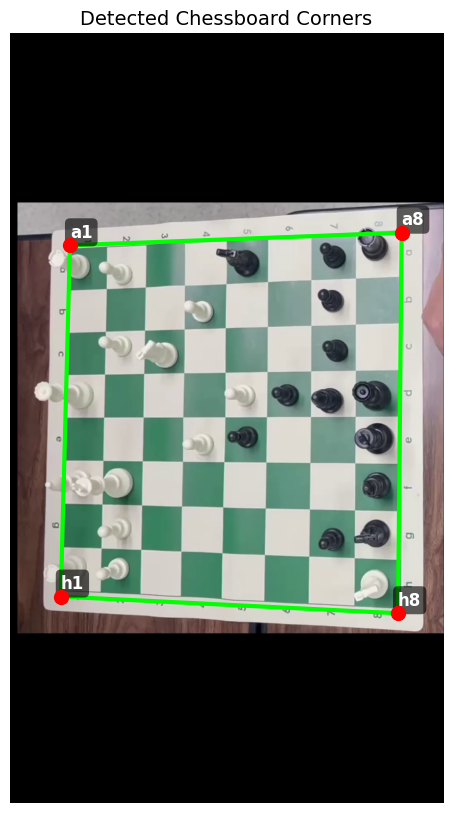

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Extract Testing Raw Frame
video_path = './2_Move_rotate_student.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    test_frame = None
    print('Error Opening Video')
else:
    ret, test_frame = cap.read()

# Predict Chessboard corners
if test_frame is not None:
    # Convert BGR to RGB
    test_frame_rgb = cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB)

    # Predict the Corners
    results = pose_model(test_frame, conf=0.5, verbose=False)
    corners = results[0].keypoints.xy[0].cpu().numpy()

    # Visualization
    corner_names = ['a1', 'h1', 'a8', 'h8']
    plot_order = [0, 1, 3, 2, 0] # a1 -> h1 -> h8 -> a8 -> a1
    poly_x = corners[plot_order, 0]
    poly_y = corners[plot_order, 1]

    plt.figure(figsize=(10,10))
    plt.imshow(test_frame_rgb)

    # Plot line connected all 4 corners
    plt.plot(poly_x, poly_y, linewidth=3, color='lime', linestyle='-')

    # Plot corner points
    plt.scatter(corners[:, 0], corners[:, 1], s=100, c='red', marker='o', zorder=10)

    # Put text to each corner (a1, h1, ...)
    for i, name in enumerate(corner_names):
        x, y = corners[i]
        plt.text(x, y - 20, name, color='white', fontsize=12, fontweight='bold',
                 bbox=dict(facecolor='black', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.3'))

    plt.title("Detected Chessboard Corners", fontsize=14)
    plt.axis('off')
    plt.show()

### 1.4 Build `BoardLocalizer` Class
Build  class to localize and warp the chessboard in an image frame.

In [7]:
import numpy as np
import cv2
from ultralytics import YOLO
from typing import Tuple, List

class BoardLocalizer():
    """
    A class to localize and warp the chessboard in an image frame.

    Attributes:
        model_path: Path to the best.pt (board localizer YOLO-pose model).
        target_size: The desired output size (width, height) of the warped chessboard image.
        conf_thresh: Confidence threshold (0.0-1.0)

    Methods:
        - is_calibrated(): Check if the localizer is calibrated.
        - calibrate(): Calibrate the localizer using the input frame.
        - warp(): Warp the input frame to get a top-down view of the chessboard.
        - reset(): Reset the calibration.
    """
    def __init__(self,
                 model_path: str,
                 target_size: int=640,
                 conf_thresh: float=0.5
                 ):
        print(f'🔄 Loading YOLO-Pose model from {model_path}')

        # Attributes
        self.model = YOLO(model_path)
        self.target_size = target_size
        self.conf_thresh = conf_thresh

        # Memories
        self.M = None # Perspective Transform Matrix (3 x 3)
        self.is_locked = False
        self.locked_points = None

        # Destination points for for the perspective transform
        self.dst_points = np.array([
            [0, target_size],                  # a1: x=0, y=640
            [target_size, target_size],        # h1: x=640, y=640
            [0, 0],                            # a8: x=0, y=0
            [target_size, 0]                   # h8: x=640, y=0
        ], dtype=np.float32)

    def reset(self):
        """
        (Main Method) Reset the stored memory if cammera position have changed.
        """
        print('🔃 Board Localizer Reset!')
        self.M = None
        self.is_locked = False
        self.locked_points = None

    def _attempt_calibration(self, frame: np.ndarray) -> bool:
        """
        (internal method) Attempt to find 4 corner points of the chessboard
        and calculate the perspective transform matrix M

        Args:
            frame: Input image frame.
        Returns:
            bool: True if calibration is successful, False otherwise.
        """
        # 1. Run inference on frame using trained YOLO-pose model.
        results = self.model(frame, conf=self.conf_thresh, verbose=False)

        # 2. Check Detections
        if len(results) == 0 or len(results[0].keypoints) == 0:
            return False # chessboard not found

        # 3. Extract keypoints of the first board detected
        # shape: (4, 2) -> a1_corner, h1_corner, a8_corner, h8_corner respectively
        kpts = results[0].keypoints.xy[0].cpu().numpy()
        confs = results[0].keypoints.conf[0].cpu().numpy()

        # 4. Valiadate logic
        # condition A: a valid corner point must have x, y coordinate >= 0.
        # In this case we check if all 4 keypoints is valid or not.
        if np.any(kpts <= 0):
            return False

        # condition B: valid corners points must have average confidence > conf threshold
        if np.mean(confs) < self.conf_thresh:
            return False

        # 5. Calculate matrix M and lock
        self.M = cv2.getPerspectiveTransform(kpts.astype(np.float32), self.dst_points)
        self.is_locked = True
        self.locked_points = kpts.astype(np.float32)

        print(f'✅ Board Localizer Calibration Locked! (Average Conf: {np.mean(confs):.2f})')
        return True

    def get_locked_points(self):
        """
        (Main method) get the locked 4 corner points
        """
        return self.locked_points

    def get_warped_frame(self, frame: np.ndarray) -> np.ndarray | None:
        """
        (Main method) Warp the input frame to get a top-down view of the chessboard of size (640, 640).
        which the layout is
            - top left: a8_corner
            - top right: h8_corner
            - bottom left: a1_corner
            - bottom right: h1_corner

        Args:
            frame (np.ndarray): Input image frame
        Returns:
            np.ndarray or None: warped board from top-down view of size (640, 640).
            or return None if M is not memorized yet.
        """
        # case 1: If not locked -> attempting calibrate on this frame
        if not self.is_locked:
            success = self._attempt_calibration(frame)
            if not success:
                return None

        # If locked: Create a warped board on this frame
        warped = cv2.warpPerspective(frame,
                                     M=self.M,
                                     dsize=(self.target_size, self.target_size)
                                     )

        return warped

🔄 Loading YOLO-Pose model from https://huggingface.co/surawut/chess-move-tracking-yolo11/resolve/main/models/yolo11s_pose_chessboard.pt
Found https://huggingface.co/surawut/chess-move-tracking-yolo11/resolve/main/models/yolo11s_pose_chessboard.pt locally at weights/yolo11s_pose_chessboard.pt
✅ Board Localizer Calibration Locked! (Average Conf: 1.00)


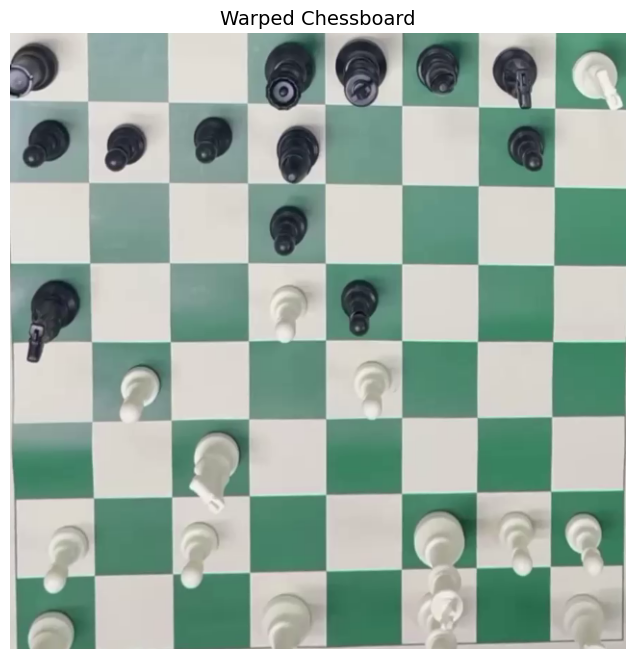

🔃 Board Localizer Reset!


In [8]:
# Visualize the output from Boardlocalizer to get the warped perspective
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Setup BoardLoacalizer
POSE_MODEL_URL = 'https://huggingface.co/surawut/chess-move-tracking-yolo11/resolve/main/models/yolo11s_pose_chessboard.pt'
localizer = BoardLocalizer(model_path=POSE_MODEL_URL, target_size=640, conf_thresh=0.5)

if test_frame is not None:
    # Convert BGR to RGB
    test_frame_rgb = cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB)
    # Get the warped board
    warped = localizer.get_warped_frame(test_frame_rgb)
    # Visualization
    plt.figure(figsize=(8,8))
    plt.imshow(warped)
    plt.title("Warped Chessboard", fontsize=14)
    plt.axis('off')
    plt.show()

localizer.reset()

## ♟️ Phase 2: Piece Detection

**Objective:** To identify chess pieces position and their classes on the warped board.

### ⚙️ Methodology:
We use a pretrained **YOLO11m** as a baseline model and fine-tuned it on custom chess pieces dataset then the model is run on the 640x640 warped image. The model is trained to recognize 13 classes: 12 chess pieces (`wP`, `bK`, etc.) and a `Hand` class.

### 2.1 Dataset Preparation
To train the YOLOv11-Detect model for robust chess piece recognition, a specialized dataset was constructed focusing on the "rectified" (top-down) view of the chessboard.  See more details about this dataset [here](https://huggingface.co/datasets/surawut/chess-pieces-dataset-yolo).

**Data Source & Generation:** The base dataset was generated by processing raw video clips—specifically `2_Move`, `2_Move_rotate`, `6_Move`, `8_Move`, and `(Bonus)Long_video`—through the Phase 1 `BoardLocalizer`. This process applied perspective warping to each frame, resulting in standardized 640x640 top-down images where the board grid is geometrically aligned.

**Splitting Strategy:** The generated warped frames were randomly split using an 80:20 ratio:
- Training Set (Base): 769 images (80%)
- Validation Set: 192 images (20%)

**Labeling (13 Total Classes):**
- **Pieces:** `wP`, `wR`, `wN`, `wB`, `wQ`, `wK`, `bP`, `bR`, `bN`, `bB`, `bQ`, `bK`.
- **Utility:** `Hand` (Used to filter unstable frames).

**Preprocessing:** The following pre-processing was applied to each image.
- Auto-orientation of pixel data (with EXIF-orientation stripping)
- Resize to 640x640 (Stretch)

**Augmentation Pipeline:** To enhance model generalization and prevent overfitting, the training set underwent a rigorous augmentation process:

1. **Primary Augmentation**: The base training images were augmented by a factor of 3x, expanding the count from 769 to 2,307 images. The following augmentation was applied to create 3 versions of each source image:
    * 50% probability of horizontal flip
    * 50% probability of vertical flip
    * Random brigthness adjustment of between -20 and +20 percent
    * Random exposure adjustment of between -15 and +15 percent

2. **Additional Data Integration**: An external dataset of 638 pre-augmented images (curated for diverse scenarios or negative samples) was integrated into the training pipeline to further boost robustness.

**Final Dataset Composition:** The final dataset structure used for training is summarized below:

| Split | Base Images | Post-Augmentation (3x)| Additional Data | Total Examples |
| :--- | :--- | :--- | :--- | :--- |
| **Train** | 769  | 2307 | 638 | 2945 |
| **Valid** | 192  | 192 | - | 192 |

### 2.2 YOLO11m Model Evaluation Results

In [9]:
# Download the Pieces dataset
google_drive_link = "https://drive.google.com/file/d/1FwI0Sfg8dlwCrv4Rx6GF6kRl0WjgXJ-q/view?usp=sharing"
download_and_extract_gdrive(google_drive_link, output_folder="./chess-pieces-dataset")

⬇️ Downloading file (ID: 1FwI0Sfg8dlwCrv4Rx6GF6kRl0WjgXJ-q)...


Downloading...
From (original): https://drive.google.com/uc?id=1FwI0Sfg8dlwCrv4Rx6GF6kRl0WjgXJ-q
From (redirected): https://drive.google.com/uc?id=1FwI0Sfg8dlwCrv4Rx6GF6kRl0WjgXJ-q&confirm=t&uuid=ca32733f-b846-4e15-8bd7-691447ae0859
To: /content/temp_download.zip
100%|██████████| 131M/131M [00:02<00:00, 46.2MB/s]


📦 Extracting to './chess-pieces-dataset'...
✅ Extraction complete!
🧹 Removed temporary zip file.


In [10]:
# Validate the YOLO11 model on validation set
from ultralytics import YOLO

# Setup Model
PIECE_MODEL_URL = 'https://huggingface.co/surawut/chess-move-tracking-yolo11/resolve/main/models/yolo11m_pieces.pt'
piece_model = YOLO(PIECE_MODEL_URL)

# Validation on validation set
val_results = piece_model.val(
        data='./chess-pieces-dataset/data.yaml',
        split='val',
        project='./runs/validation',
        name='yolo11m_val',
        batch=16,
        save=True,
        exist_ok=True,
        verbose=True
)

results_dict = val_results.results_dict
print(f'\nBox Precision: {results_dict["metrics/precision(B)"]}')
print(f'Box Recall: {results_dict["metrics/recall(B)"]}')
print(f'Box mAP50: {results_dict["metrics/mAP50(B)"]}')
print(f'Box mAP50-95: {results_dict["metrics/mAP50-95(B)"]}')

Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,040,055 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1656.1±467.4 MB/s, size: 40.3 KB)
val: Scanning /content/chess-pieces-dataset/valid/labels... 192 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 192/192 2.2Kit/s 0.1s
val: New cache created: /content/chess-pieces-dataset/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 1.6it/s 7.5s
                   all        192       4893      0.996      0.993      0.995      0.978
                  Hand        151        155      0.986      0.981      0.992      0.924
                    bB        189        260          1          1      0.995      0.986
                    bK        190        190      0.999          1      0.995      0.991
                    bN        137        206      0.99

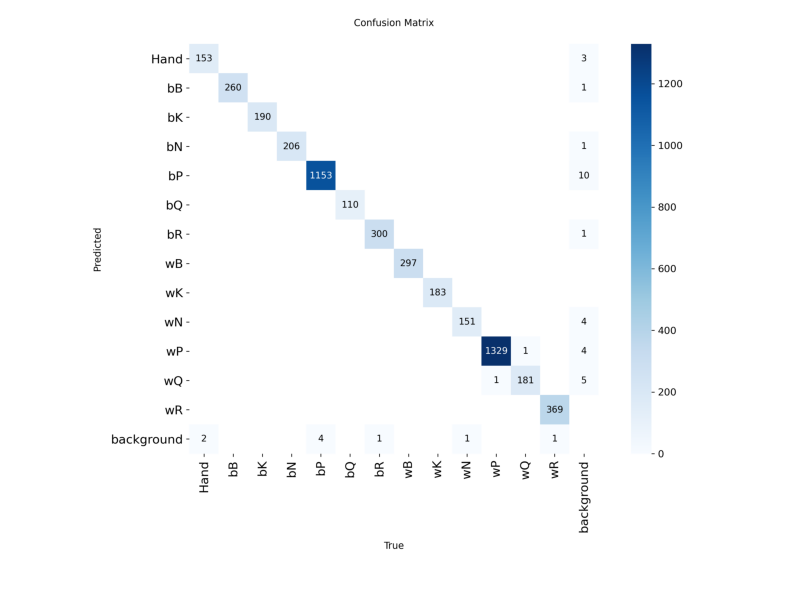

In [11]:
# Confusion Matrix
import cv2
import matplotlib.pyplot as plt

conf_matrix_path = './runs/validation/yolo11m_val/confusion_matrix.png'
conf_matrix = cv2.imread(conf_matrix_path)
plt.figure(figsize=(10,10))
plt.imshow(conf_matrix[:,:,::-1])
plt.axis(False)
plt.show()

### 2.3 Visualize the Fine-tuned `YOLO11m` Output

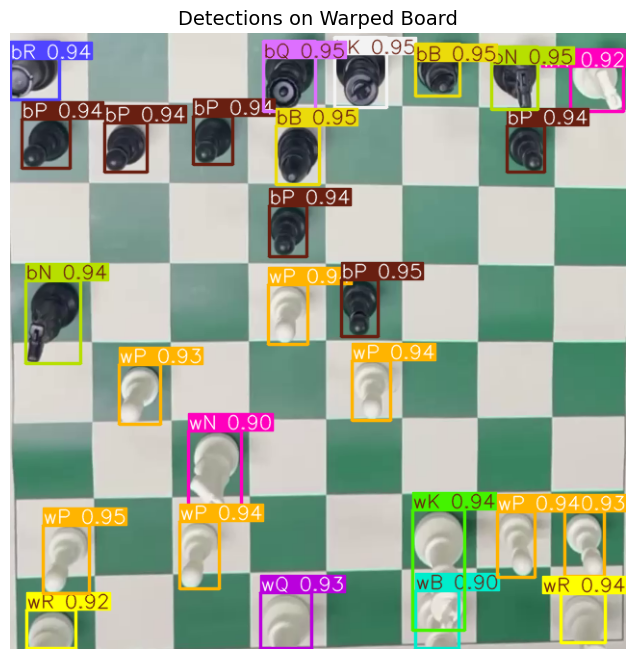

In [12]:
# Visualize the output from using Boardlocalizer to get the warped perspective
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Device agnostic code
device = '0' if torch.cuda.is_available() else 'cpu'

# Detect Pieces in warped frame
results = piece_model.predict(
    warped,
    imgsz=640,
    conf=0.25,
    device=device,
    verbose=False
)

# Visualization
plt.figure(figsize=(8,8))
plt.imshow(results[0].plot())
plt.title("Detections on Warped Board", fontsize=14)
plt.axis('off')
plt.show()

## 🧠 Phase 3: State Analysis (The Logic Core)

**Objective:** To translate raw bounding boxes into logical board states and detect move events.

**Methodology:**
1.  **Coordinate Mapping:** Bounding boxes are mapped to the 8x8 grid using their *top-center* coordinates.
2.  **Temporal Stability:** A board state must remain unchanged for `N` frames to be confirmed, filtering out flicker and hand movements.
3.  **Active Color Detection:** The system waits for the first move to determine who started (White or Black), enabling mid-game initialization.

### 3.1 Build `ChessStateAnalyzer` Class

In [13]:
"""
A class for analyzing the temporal sequence of the chessboard states to detect and confirm chess move.
"""
import numpy as np
from collections import Counter
from typing import List, Dict, Tuple

class ChessStateAnalyzer:
    """
    This  class acts as a filter and a state machine. It takes raw object detections from
    each video frame, convert them into a logical board representation (dictionary),
    and use temporal stability analysis to filter out noise (e.g., hand occlusions,
    flickering detections). It identifies when a move has settled and determines the
    'from' to 'to' squares.

    Attributes:
        - square_size (float): The pixel width/height of a single square on the warped board.
        - stability_thresh (int): The number of consecutive identical frames required to confirm a new board state.
        - files (list): Mapping of column indices (0-7) to file letter ('a'-'h').
        - ranks (list): Mapping of row indices (0-7) to rank numbers ('8'-'1').
        - prev_stable_board (dict): The last confirmed board state (before the current move).
        - candidate_board_str (str): The string representation of the board state currently being verified for stability.
        - stability_counter (int): A counter tracking how many consecutive frames the candidate state has remained unchanged.
        - initial_board_state (dict): The initial board state before the fist move occure.
        - game_initialized (bool): A boolean tells whether the first move has already occured  or not.
    """
    def __init__(self, board_size: int=640, stability_thresh: int=10):

        """
        Initialize the ChessStateAnalyzer.

        Args:
            board_size (int): The dimension (width/height) of the warped chessboard image in pixels.Defaults to 640.
            stability_thresh (int): The number of consecutive frames a state must remain constant to be accepted as stable. Default to 10.

        """
        self.board_size = board_size
        self.square_size = board_size / 8
        self.stability_thresh = stability_thresh

        # Mapping for converting grid coordinates to algebraic notation.
        # Note: In image coordinates, y=0 is the top (Rank 8), y=max is the bottom (Rank 1).
        self.files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',]
        self.ranks = ['8', '7', '6', '5', '4', '3', '2', '1']

        # State Machine Memory
        self.prev_stable_board_state = None
        self.candidate_board_str = None
        self.stability_counter = 0

        # Initial Board State Memory
        self.initial_board_state = None
        self.game_initialized = False

    def _get_square_from_xy(self, x: float, y: float) -> str:

        """
        (internal method) Convert pixels coordinates (x, y) into a chess square notation (e.g., 'e4')

        Args:
        x (float): The x-coordinate on the warped board image.
        y (float): The y-coordinate on the warped board image.

        Returns:
            str: The algebraric notation of the square (e.g., 'a1', 'h8').
        """
        col = int(x // self.square_size)
        row = int(y // self.square_size)

        # Clamp values to 0-7 to prevent crashes if a detection is slightly out of bounds
        col = max(0, min(7, col))
        row = max(0, min(7, row))

        return self.files[col] + self.ranks[row]

    def detections_to_board(self, detections: List) -> Dict[str, str] | None:
        """
        (main mathod) Convert a list of YOLO detections into a logical board dictionary.

        This method maps each detected bounding box to a specific square on chessboard.
        It uses the 'top-center' point of the bounding box to detemine the square,
        which is more robust to perspective distortion than the center point.
        It also handles conflicts (multiple pieces on one square) by keeping the one with higher confidence.

        Args:
            detections (list): A list of detections, where each detection is a list:
            [x1, y1, x2, y2, confidence, class_id, class_name].

        Returns:
            dict: A dictionary representing the board state, where keys are square names (e.g., 'e4')
                  and values are pieces classes (e.g., 'wP').
            None: If a 'Hand' is detected, indicating the frame is unstable/occluded.

        """
        board_state = {}
        conf_map = {}

        for box in detections:
            x1, y1, x2, y2 = box[:4]
            conf = box[4]
            cls_name = box[6]

            # Stability Check: If a hand is visible, the board state is unreliable.
            if cls_name == 'Hand':
                return None

            # Logic: Calculate the reference point (top-center) of the box.
            # We use y1 (top edge) and move slightly down (25%)
            ref_x = (x1 + x2) / 2
            ref_y = y1 + 0.25 * (y2 - y1)

            square = self._get_square_from_xy(ref_x, ref_y)

            # Conflict Resolution:
            # If a square is already occupied by another detection (e.g., overlapping boxes),
            # keep the detection with the higher confidence score.
            if square in board_state:
                if conf > conf_map[square]:
                    board_state[square] = cls_name
                    conf_map[square] = conf
            else:
                board_state[square] = cls_name
                conf_map[square] = conf

        return board_state


    def _detect_move_diff(self,
                          old_board: Dict[str, str],
                          new_board: Dict[str, str]) -> Tuple[str] | None:
        """
        (internal method) Compares two stable board states to deduce the move that occurred.

        It identifies squares that have changed (pieces disappeared, appeared, or changed type)
        and infers the source and destination squares.

        Args:
            old_board (Dict): The board state before the move.
            new_board (Dict): The board state afer the move.

        Returns:
            tuple: A tuple (from_square, to_square) representing the detected move
                    (e.g., ('e2', 'e4')).
            None: If the difference logic cannot determine a valid single move.
        """
        # Identify all squares where the state differs between old and new boards
        all_squares = set(old_board.keys()) | set(new_board.keys())
        diff_squares = set()

        for sq in all_squares:
            piece_old = old_board.get(sq)
            piece_new = new_board.get(sq)
            if piece_old != piece_new:
                diff_squares.add(sq)

        from_sq, to_sq = None, None

        # Infer Move Logic
        for sq in diff_squares:
            piece_old = old_board.get(sq)
            piece_new = new_board.get(sq)

            # Case 1: Source Square
            # A piece existed here in the old board state but is gone in the new board state.
            if piece_old and not piece_new:
                from_sq = sq

            # Case 2: Destination Square (Move or Capture)
            # A piece exists here in the new board (it was empty before OR occupied by an opponent).
            elif piece_new:
                to_sq = sq

        if from_sq and to_sq:
            return (from_sq, to_sq)

        # If diff_squares set have < 2 different squares
        return None


    def process_frame(self, detections: List) -> Dict | None:
        """
        (main method) The main processing loop to be called on every video frame.

        This method handles the temporal stability logic. It waits for the board state
        to remain consistent for `stability_thresh` frames before confirming a change.
        Once confirmed, if the state differs from the previous stable state, it triggers
        move detection.

        The method operates in two main phases:
        1. Initialization Phase: It waits for the first valid move to occur to
           determine the active color (who moved first) and establish the initial FEN.
        2. Game Loop Phase: Once initialized, it tracks standard moves by comparing
           the current stable state with the previous one.


        Args:
            detections (List): Raw YOLO detections for the current frame.
                               where each detection is a list:
                               [x1, y1, x2, y2, confidence, class_id, class_name].

        Returns:
            dict | None:
            - Returns **None** if the board is unstable, occluded (hand detected),
              or if no new move has been confirmed yet.
            - Returns an **Event Dictionary** if a significant event occurs:
                > Type 'first_move': When the first move is detected.
                  Structure: `{'type': 'first_move', 'initial_board': dict, 'active_color': str, 'move': tuple}`
                > Type 'move': For subsequent moves.
                  Structure: `{'type': 'move', 'move': (from_sq, to_sq)}`
        """
        # 1. Convert raw detections to a logical board state
        current_board_state = self.detections_to_board(detections)

        # 2. Reset if unstable (Hand detected or empty/invalid board)
        if current_board_state is None or len(current_board_state) < 2:
            self.stability_counter = 0
            self.candidate_board_str = None
            return None

        # Serialize the board to string for easy comparison
        # (e.g., "[('a1', 'wR'), ('a2', 'wP')...]")
        current_board_str = str(sorted(current_board_state.items()))

        # 3. Check for Stability
        if current_board_str == self.candidate_board_str:
            self.stability_counter += 1
        else:
            # State changed (flickering or piece moved) -> Reset counter and start tracking new candidate
            self.candidate_board_str = current_board_str
            self.stability_counter = 0

        # 4. Check Threshold
        if self.stability_counter >= self.stability_thresh:


            # ---- 1. Initialization Phase ----
            if not self.game_initialized:

                # A: Initial Board State is Not in Memory
                if self.initial_board_state is None:
                    self.initial_board_state = current_board_state
                    print('⏳ Waiting for the first move to determine active color...')
                    return None

                # B: Initial Board State is already in Memory -> wait until first the move occure
                prev_board_str = str(sorted(self.initial_board_state.items()))

                if current_board_str != prev_board_str:
                    # (first move) Analyze the difference to find the move
                    move = self._detect_move_diff(self.initial_board_state, current_board_state)
                    if move:
                        from_sq, to_sq = move
                        # Get the color of the moving piece
                        moving_piece = self.initial_board_state.get(from_sq)

                        if moving_piece:
                            # 'wP' -> 'w', 'bK' -> 'b'
                            active_color = moving_piece[0]

                            # Update memory to the new state
                            self.game_initialized = True
                            self.prev_stable_board_state = current_board_state
                            self.stability_counter = 0

                            print(f'✅ First Move Detected: {active_color} moves {from_sq}->{to_sq}')

                            # Return Event 'first_move'
                            return {
                                'type': 'first_move',
                                'initial_board_state': self.initial_board_state,
                                'active_color': active_color,
                                'move': move # e.g., ('e2', 'e4')
                            }

            # ---- 2. Game Loop Phase -----
            else:
                prev_board_str = str(sorted(self.prev_stable_board_state.items()))

                if current_board_str != prev_board_str:
                    # (subsequence move) Analyze the difference to find the move
                    move = self._detect_move_diff(self.prev_stable_board_state, current_board_state)
                    # Update memory to the new state
                    if move:
                        self.prev_stable_board_state = current_board_state
                        self.stability_counter = 0

                        # Return Event 'move'
                        return {
                            'type': 'move',
                            'move': move
                        }

        return None

### Example: Change Detections from the YOLO11 into a Board State Dict

In [14]:
# Format Detections
detections = []
if results[0].boxes:
    for box in results[0].boxes:
        x1, y1, x2, y2 = box.xyxy[0].cpu().tolist()
        conf = box.conf.cpu().item()
        cls_id = int(box.cls.cpu().item())
        cls_name = piece_model.names[cls_id]
        detections.append([x1, y1, x2, y2, conf, cls_id, cls_name])

# Setup ChessStateAnalyzer
analyzer = ChessStateAnalyzer(640, 10)
board_state = analyzer.detections_to_board(detections)

print(f'Number of pieces detected: {len(board_state)}')
print(f'Board State:\n {board_state if board_state is not None else "Board state is not detected."}')

Number of pieces detected: 27
Board State:
 {'d7': 'bB', 'a2': 'wP', 'e5': 'bP', 'd8': 'bQ', 'f8': 'bB', 'e8': 'bK', 'g8': 'bN', 'd5': 'wP', 'c7': 'bP', 'g2': 'wP', 'a7': 'bP', 'g7': 'bP', 'd6': 'bP', 'a8': 'bR', 'e4': 'wP', 'b7': 'bP', 'h1': 'wR', 'f2': 'wK', 'a5': 'bN', 'c2': 'wP', 'd1': 'wQ', 'h2': 'wP', 'b4': 'wP', 'a1': 'wR', 'h8': 'wN', 'c3': 'wN', 'f1': 'wB'}


## 📜 Phase 4: Rules Validation & PGN Generation

**Objective:** To validate the visual moves against official chess rules and generate a standard PGN file.

**Methodology:**
We use the `python-chess` library as a referee.
1.  **FEN Generation:** A utility function converts the detected board dictionary into a FEN string. It includes logic to auto-detect the standard starting position or fallback to mid-game dynamic rights.
2.  **Validation:** Every move from Phase 3 is checked. Illegal moves (visual errors) are rejected.
3.  **PGN Export:** Valid moves are recorded and formatted cleanly.

### 4.1 Build `ChessPGNGenerator` Class

In [15]:
"""
A class responsible for validating chess moves, maintaining the game state,
and generating Portable Game Notation (PGN) records.
"""
import chess
import chess.pgn
import re
from datetime import datetime
from typing import List, Optional

class ChessPGNGenerator:
    """
    A class responsible for validating moves using chess rules and generating PGN records.

    This class acts as a bridge between the computer vision pipeline and the official
    chess rules (via the `python-chess` library). It handles:
    1. Validating raw moves (e.g., 'e2' -> 'e4') against the current board state.
    2. Maintaining the game state (handling captures, castling, en passant).
    3. Constructing the PGN game tree (Standard Algebraic Notation).
    4. Supporting mid-game initialization via FEN strings.
    """
    def __init__(self, event_name:str='Chess Move Tracking'):
        """
        Initializes the ChessPGNGenerator.

        Attributes:
            board (chess.Board): The internal representation of the chess board state.
            game (chess.pgn.Game): The root object of the PGN game tree.
            node (chess.pgn.GameNode): A pointer to the current move in the game tree.
            event_name (str): The name of the tournament or match.
        """
        # 1. Initialize an empty standard board
        self.board = chess.Board()

        # 2. Create a PGN Game object to store headers and moves
        self.game = chess.pgn.Game()

        # 3. Set standard headers
        self.game.headers['Event'] = event_name
        self.game.headers['Date'] = datetime.now().strftime('%Y.%m.%d')

        # 4. Initialize the 'node' pointer to the root of the game
        # (This pointer will move forward as we add moves)
        self.node = self.game

    def set_board_from_fen(self, fen_str: str) -> bool:
        """
        (Main Method) Initializes the board from a specific FEN string (for mid-game scenarios).

        Args:
            fen_str (str): The Forsyth-Edwards Notation string representing the board state.

        Returns:
            bool: True if the FEN is valid and set successfully, False otherwise.
        """
        try:
            # 1. Update the internal board state
            self.board = chess.Board(fen_str)

            # 2. Tell the PGN object that this game starts from a specific position
            # (This adds the 'FEN' and 'SetUp' headers automatically)
            self.game.setup(self.board)

            # 3. Reset the node pointer to the root (clearing previous history if any)
            self.node = self.game

            return True

        except ValueError:
            print(f'❌ Invalid FEN string provided: {fen_str}')
            return False


    def _is_promotion(self, move: chess.Move) -> bool:
        """
        (Internal method) Checks if a proposed move results in a pawn promotion.

        Since computer vision detects 'from' and 'to' squares but not the promotion
        piece choice, we need to detect this scenario to auto-promote (usually to Queen).

        Args:
            move (chess.Move): The move object to check.

        Returns:
            bool: True if the move is a pawn advancing to the last rank (rank 1 or 8),
                  False otherwise.
        """
        # Check if the piece is a PAWN
        piece = self.board.piece_at(move.from_square)

        if piece and piece.piece_type == chess.PAWN:
            rank = chess.square_rank(move.to_square)

            # Rank 0 is White's 1st rank (promotion for Black)
            # Rank 7 is White's 8th rank (promotion for White)
            if rank == 0 or rank == 7:
                return True
        return False

    def push_move(self, from_sq: str, to_sq: str, ignore_rules: bool=False) -> Optional[str]:
        """
        Validates and applies a move to the board, returning the SAN string.

        Args:
            from_sq (str): Source square (e.g., 'e2').
            to_sq (str): Destination square (e.g., 'e4').
            ignor_rules (bool): whether to ignore legality for chess moving. If True, ignor the rules.
                                If False, otherwise.

        Returns:
            san_move (str): The move in Standard Algebraic Notation (e.g., 'Nf3', 'exd5') if valid.
                            Returns None if 'ignore_rule' = False and the move is illegal.
        """
        try:
            # 1. Convert raw strings to Move object (UCI format)
            uci_str = f'{from_sq}{to_sq}'
            move = chess.Move.from_uci(uci_str)

            # 2. Handle Auto-Promotion
            # If it's a promotion, we MUST specify the promotion piece (defaulting to Queen)
            # otherwise, legal_moves check will fail.
            if self._is_promotion(move):
                move.promotion = chess.QUEEN

            if not ignore_rules:
                # 3. Check Legality (The Rule Engine)
                if move in self.board.legal_moves:
                    # 4. Convert to SAN (e.g., 'e4', 'O-O')
                    san_move = self.board.san(move)
                    # 5. Add the move to the PGN tree .add_variation() creates a new child node and returns it
                    self.node = self.node.add_variation(move)
                    # 6. Update the internal board state
                    self.board.push(move)
                    return san_move
                else:
                    # Move logic is impossible (e.g., Knight jumping incorrectly)
                    return None
            else:
                san_move = self.board.san(move)
                self.node = self.node.add_variation(move)
                self.board.push(move)
                return san_move

        except Exception as e:
            print(f'🔴 Error processing move {from_sq}->{to_sq}: {e}')
            return None

    def get_pgn_string(self, headers: bool=True, clean_format: bool=False) -> str:
        """
        Exports the complete game history as a PGN formatted string.

        Args:
            headers (bool): Wheter or not to keep the headers in output. Default to True
            clean_format (bool): If true, removes '*' and converts '1...' to '1.'

        Returns:
            str: The full PGN string including headers and move list.
        """
        # StringExporter is the standard way to format PGNs in python-chess
        exporter = chess.pgn.StringExporter(headers=headers, variations=True, comments=False)
        pgn_raw = self.game.accept(exporter)

        if clean_format:
            # delete * at the end (if any)
            pgn_clean = re.sub(r"\s+(1-0|0-1|1\/2-1\/2|\*)$", "", pgn_raw)
            # replace ... with .
            pgn_clean = pgn_clean.replace('...', '.')
            # delete \n
            pgn_clean = pgn_clean.replace('\n', ' ')
            # delete double spaces
            pgn_clean = re.sub(r"\s+", " ", pgn_clean)

            return pgn_clean.strip()

        return pgn_raw

    def save_pgn_file(self, filename: str='game.pgn'):
        """
        Saves the PGN string to a text file.

        Args:
            filename (str): PGN filename.

        """
        pgn_content = self.get_pgn_string()

        try:
            with open(filename, 'w') as f:
                f.write(pgn_content)
            print(f"💾 PGN successfully saved to: {filename}")
        except IOError as e:
            print(f'❌ Could not write to file: {e}')

### 4.2 Build a Utility Function Converts the Board State into a FEN String.

In [16]:
from typing import Dict


def generate_fen_from_dict(board_state: Dict[str, str], active_color: str) -> str:
    """
    Converts a dictionary representation of the board into a FEN string.

    This function generates the Forsyth-Edwards Notation (FEN) string based on the
    visual detection of pieces. It includes intelligent logic to handle both
    the standard starting position and arbitrary mid-game positions.

    Args:
        board_state (Dict): A dictionary mapping square coordinates to piece codes
                            (e.g., {'e4': 'wP', 'a1': 'wR'}).

        active_color (str): The color of the player to move next ('w' for White, 'b' for Black).

    Returns:
        str: A valid FEN string representing the board state
             (e.g., "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1").
    """
    # ---- 1. Construct Position String for Piece Placement -----
    piece_rows = []
    files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',]
    ranks = ['8', '7', '6', '5', '4', '3', '2', '1']

    for rank in ranks:
        empty_count = 0
        row_str = ''
        for file in files:
            square = file + rank
            if square in board_state:
                if empty_count > 0:
                    row_str += str(empty_count)
                    empty_count = 0

                piece_code = board_state[square]
                color = piece_code[0]
                role = piece_code[1]
                symbol = role.upper() if color == 'w' else role.lower()
                row_str += symbol
            else:
                empty_count += 1

        if empty_count > 0:
            row_str += str(empty_count)
        piece_rows.append(row_str)

    piece_placement = '/'.join(piece_rows)

    # ----- 2. Check for Standard Starting Position ----
    STANDARD_START_PLACEMENT = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR'

    if piece_placement == STANDARD_START_PLACEMENT and active_color == 'w':
        # Exact match for the standard start: return full rights immediately
        return "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"


    # ----- 3. Mid-Game Logic (Dynamic Castling Rights) ----
    # If positions don't match the start, calculate castling rights based on
    # the presence of Kings and Rooks on their starting squares.

    castling_rights = ''

    # Check White Rights
    if board_state.get('e1') == 'wK':
        if board_state.get('h1') == 'wR':
            castling_rights += 'K'
        if board_state.get('a1') == 'wR':
            castling_rights += 'Q'

    # Check Black Roght
    if board_state.get('e8') == 'bK':
        if board_state.get('h8') == 'bR':
            castling_rights += 'k'
        if board_state.get('a8') == 'bR':
            castling_rights += 'q'

    if castling_rights == '':
        castling_rights = '-'

    # Defaults for undetermined states
    # En Pasant (-), Halfmove (0), Fullmove(1)
    return f'{piece_placement} {active_color} {castling_rights} - 0 1'

### Example: Convert Board State into a FEN String and Visualize the Board

FEN String: r2qkbnN/pppb2p1/3p4/n2Pp3/1P2P3/2N5/P1P2KPP/R2Q1B1R b q - 0 1


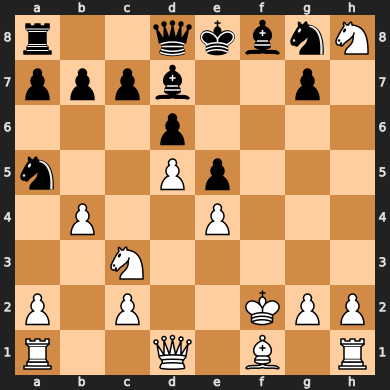

In [17]:
# Setup ChessPGNGenerator
pgn_engine = ChessPGNGenerator()

# Convert Board State Dict from Phase 3 into FEN String
fen_string = generate_fen_from_dict(board_state=board_state, active_color='b')

# Visualize the board using 'python-chess' library
pgn_engine.set_board_from_fen(fen_string)
print(f'FEN String: {fen_string}')
pgn_engine.board

## 🎬 Phase 5: Running the Pipeline

The following block runs the full pipeline on a sample video.
1.  Downloads and initializes fine-tuned models from Hugging Face.
2.  Build a Pipeline to Processe the video frame-by-frame.
3.  Outputs the PGN log in real-time.

### 5.1 Downloads and Initializes Models

In [18]:
from ultralytics import YOLO

# Fine-tuned YOLO11s-pose models from Hugging Face
POSE_MODEL_URL = 'https://huggingface.co/surawut/chess-move-tracking-yolo11/resolve/main/models/yolo11s_pose_chessboard.pt'
localizer = BoardLocalizer(model_path=POSE_MODEL_URL)

🔄 Loading YOLO-Pose model from https://huggingface.co/surawut/chess-move-tracking-yolo11/resolve/main/models/yolo11s_pose_chessboard.pt
Found https://huggingface.co/surawut/chess-move-tracking-yolo11/resolve/main/models/yolo11s_pose_chessboard.pt locally at weights/yolo11s_pose_chessboard.pt


In [19]:
from ultralytics import YOLO

# Fine-tuned YOLO11m Model from Hugging Face
PIECE_MODEL_URL = 'https://huggingface.co/surawut/chess-move-tracking-yolo11/resolve/main/models/yolo11m_pieces.pt'
piece_model = YOLO(PIECE_MODEL_URL)

Found https://huggingface.co/surawut/chess-move-tracking-yolo11/resolve/main/models/yolo11m_pieces.pt locally at weights/yolo11m_pieces.pt


In [20]:
# Device Agnostic Code
import torch

device = '0' if torch.cuda.is_available() else 'cpu'
device

'0'

### 5.2 Build a Pipeline (`chess_move`) to Processe the video Frame-by-Frame.

In [21]:
# This function will be used for marking, do not change function name, input parameters and return parameters of this function
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def chess_move(video_name):
    """
    Detect each Chess Move from Video in SAN (Standard Algebraic Notation) format,
    and then combine it into PGN format.

    Args:
        video_name (str): Target chess video path (.mp4) to extract moves.

    Returns:
        move (str): A string represents moves in PGN format for the input video.
    """
    print(f'⏳ Processing: {Path(video_name).name}...')

    # ---- Initialize ----
    #  Chess State Analyzer
    state_analyzer = ChessStateAnalyzer(board_size=640, stability_thresh=1.5*30)
    #  PGN Engine
    pgn_engine = ChessPGNGenerator()

    # ---- Pipeline Start ----
    cap = cv2.VideoCapture(video_name)

    if not cap.isOpened():
        print('❌ Error opening video.')
        return

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break

        # Phase 1: Board Localization
        warped_board = localizer.get_warped_frame(frame)

        if warped_board is not None:
            # Phase 2: Piece Detection
            results = piece_model.predict(warped_board,
                                          imgsz=640,
                                          conf=0.25,
                                          device=device,
                                          verbose=False)
            # Format detections
            detections = []
            if results[0].boxes:
                for box in results[0].boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().tolist()
                    conf = box.conf.cpu().item()
                    cls_id = int(box.cls.cpu().item())
                    cls_name = piece_model.names[cls_id]
                    detections.append([x1, y1, x2, y2, conf, cls_id, cls_name])

            # Phase 3: State Recognition & Temporal Analysis
            event = state_analyzer.process_frame(detections)

            if event:
                # Phase 4: PGN Generation
                if event['type'] == 'first_move':
                    # ----- First Move Founded: Setting the Board -----
                    initial_board_state = event['initial_board_state']
                    active_color = event['active_color']
                    from_sq, to_sq = event['move']

                    # 1. Create FEN String from Initial Board State
                    start_fen = generate_fen_from_dict(board_state=initial_board_state, active_color=active_color)
                    print(f'🏁 Game Start Detected! Active Color: {active_color}')
                    print(f'📝 Initial FEN String: {start_fen}\n')

                    # 2. Init PGN Engine
                    pgn_engine.set_board_from_fen(start_fen)
                    # 3. Push the First Move
                    san = pgn_engine.push_move(from_sq, to_sq, ignore_rules=True)
                    if san:
                        print(f'♟️  First Move: {san}')

                elif event['type'] == 'move' :
                    # ---- Subsequence moves ----
                    from_sq, to_sq = event['move']
                    san = pgn_engine.push_move(from_sq, to_sq)
                    if san:
                        print(f'♟️  Move: {san}')

    cap.release()

    # Reset the Localizer Memory
    localizer.reset()

    # ---- OUTPUT RESULT ----
    moves = pgn_engine.get_pgn_string(headers=False, clean_format=True)
    return moves

### 5.3 Running the Pipeline and Marking the Score

In [22]:
# Running the Pipeline on Videos
import editdistance

moves_result = {}
f = open('./chess_solution_final_seen.csv', 'r')
score = 0
n = 0

print('=========================================================================================================')
for i, line in enumerate(f):
    if line == 'row_id,output,Usage,Link\n':
        continue

    video_name, moves_sol, p, link = line.split(',')
    print(f'\n📽️ Working on Video No. {i}')
    moves = chess_move(video_name)
    s = 1 - editdistance.eval(moves, moves_sol) / max(len(moves), len(moves_sol))
    score  += s

    print(f'\n✨ Your result: {moves}')
    print(f'✅ Solution: {moves_sol}')
    print(f'📌 The edit distance between your results and solution is {s}.\n')
    print('=========================================================================================================')
    n += 1
    moves_result[video_name] = moves

f.close()

if n != 0:
    print(f'🎉 Total Score: {score/n}')
    print('=========================================================================================================')


📽️ Working on Video No. 1
⏳ Processing: 2_Move_rotate_student.mp4...
✅ Board Localizer Calibration Locked! (Average Conf: 1.00)
⏳ Waiting for the first move to determine active color...
✅ First Move Detected: b moves d8->h4
🏁 Game Start Detected! Active Color: b
📝 Initial FEN String: r2qkbnN/pppb2p1/3p4/n2Pp3/1P2P3/2N5/P1P2KPP/R2Q1B1R b q - 0 1

♟️  First Move: Qh4+
♟️  Move: g3
🔃 Board Localizer Reset!

✨ Your result: 1. Qh4+ 2. g3
✅ Solution: 1. Qh4+ 2. g3
📌 The edit distance between your results and solution is 1.0.


📽️ Working on Video No. 2
⏳ Processing: 2_move_student.mp4...
✅ Board Localizer Calibration Locked! (Average Conf: 1.00)
⏳ Waiting for the first move to determine active color...
✅ First Move Detected: b moves d8->h4
🏁 Game Start Detected! Active Color: b
📝 Initial FEN String: r2qkbnN/pppb2p1/3p4/n2Pp3/1P2P3/2N5/P1P2KPP/R2Q1B1R b q - 0 1

♟️  First Move: Qh4+
♟️  Move: g3
🔃 Board Localizer Reset!

✨ Your result: 1. Qh4+ 2. g3
✅ Solution: 1. Qh4+ 2. g3
📌 The edit dista

### 5.5 Save PGN Outputs to CSV Format

In [23]:
import pandas as pd

submission_df = pd.DataFrame({
    'row_id': moves_result.keys(),
    'output': moves_result.values()
})
submission_df

,row_id,output
0,2_Move_rotate_student.mp4,1. Qh4+ 2. g3
1,2_move_student.mp4,1. Qh4+ 2. g3
2,4_Move_studet.mp4,1. f4 2. Ng6 fxg3 3. Nxh8
3,6_Move_student.mp4,1. Bxb5 2. Rxb5 b6 3. c4 Ne7 4. Rb2
4,8_Move_student.mp4,1. Qe6 Kd8 2. Qf7 c6 3. Qf2 cxd5 4. Qxa7 Rc8 5...
5,(Bonus)Long_Video_label.mp4,1. f4 d5 2. Nf3 Bf5 3. Nc3 Nc6 4. Nxd5 e6 5. N...


In [24]:
submission_df.to_csv('./submission.csv', index=False)